In [15]:

# 1) Imports des bibliothèques
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns
import matplotlib.dates as mdates



print("TF:", tf.__version__, "Keras:", keras.__version__)

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


TF: 2.20.0 Keras: 3.11.2


In [16]:
DATA_PATH = './Version_2_iot_telemetry_data/Version_2_iot_telemetry_data.csv' 

In [17]:
# Hyperparamètres
LOOK_BACK = 24            # 24 pas passés (ex: 24 h)
FORECAST_HORIZON = 6      # 6 pas futurs à prédire (ex: 6 h)
TARGET_COLS = ['temp','humidity','co','lpg']
TIME_FEATS = ['hour','day_of_week','month','weekend_flag']

BATCH_SIZE = 32
EPOCHS = 100
PATIENCE_ES = 10
PATIENCE_RLR = 5
LR_FACTOR = 0.5

OUT_DIR = Path('./Version_3_artifacts')
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR = OUT_DIR / 'Version_3_models'
SCALERS_DIR = OUT_DIR / 'Version_3s_scalers'
MODEL_DIR.mkdir(exist_ok=True)
SCALERS_DIR.mkdir(exist_ok=True)

BEST_MODEL_PATH = str(MODEL_DIR / 'Version_3_best_model.keras')
FINAL_MODEL_PATH = str(MODEL_DIR / 'Version_3_final_model.keras')
TFLITE_PATH = str(MODEL_DIR / 'Version_3_model_multi_step.tflite')


In [18]:
# 2) Chargement du dataset & préparation
# ========================================
DATA_PATH
assert os.path.exists(DATA_PATH), f"Fichier introuvable: {DATA_PATH}"

df_raw = pd.read_csv(DATA_PATH)
print("Colonnes détectées:", df_raw.columns.tolist())

# Conversion ts: souvent au format scientifique de timestamp UNIX en secondes
# -> numeric -> datetime (unit='s') puis index temporel
assert 'ts' in df_raw.columns, "Colonne 'ts' absente"
df_raw['ts'] = pd.to_datetime(pd.to_numeric(df_raw['ts'], errors='coerce'), unit='s')
df = df_raw.dropna(subset=['ts']).sort_values('ts').copy()
df.set_index('ts', inplace=True)

# Casting des cibles en float (au cas où elles sont strings)
for col in TARGET_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Taille après tri & index:", df.shape)
print(df[TARGET_COLS].head())

Colonnes détectées: ['ts', 'device', 'co', 'humidity', 'light', 'lpg', 'motion', 'smoke', 'temp']
Taille après tri & index: (405184, 8)
                                    temp   humidity        co       lpg
ts                                                                     
2020-07-12 00:01:34.385974646  22.700000  51.000000  0.004956  0.007651
2020-07-12 00:01:34.735567570  19.700001  76.000000  0.002840  0.005114
2020-07-12 00:01:38.073572874  22.600000  50.900000  0.004976  0.007673
2020-07-12 00:01:39.589145899  27.000000  76.800003  0.004403  0.007023
2020-07-12 00:01:41.761234999  22.600000  50.900000  0.004967  0.007664


In [19]:
# 3) Feature engineering temporel
# =====================================
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['weekend_flag'] = df.index.dayofweek.isin([5,6]).astype(int)
print("Features temporelles ajoutées:", TIME_FEATS)

Features temporelles ajoutées: ['hour', 'day_of_week', 'month', 'weekend_flag']


In [20]:
# 4) Gestion des NaN & anomalies simples
# ============================================
# Interpolation linéaire + backward fill (bfill) comme demandé
nans_before = df.isna().sum().sum()
df = df.interpolate(method='linear', limit_direction='both')
df = df.bfill()
nans_after = df.isna().sum().sum()
print(f"NaN avant: {nans_before}, après interpolation+bfill: {nans_after}")

# Clamp léger de sûreté (optionnel)
if 'temp' in df.columns:
    df['temp'] = df['temp'].clip(-40, 80)
if 'humidity' in df.columns:
    df['humidity'] = df['humidity'].clip(0, 100)


NaN avant: 0, après interpolation+bfill: 0


C:\Users\Macky\AppData\Local\Temp\ipykernel_11904\1863139166.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', limit_direction='both')


In [21]:
# 5) Normalisation (MinMax)
# =============================
# On garde **uniquement** les features numériques utiles
feature_cols = [c for c in TARGET_COLS] + TIME_FEATS
print("Features utilisées pour le modèle:", feature_cols)

scaler_all = MinMaxScaler()
X_all_scaled = scaler_all.fit_transform(df[feature_cols].astype(float).values)

# Scaler pour (uniquement) les 4 cibles
scaler_y = MinMaxScaler()
Y_all_scaled = scaler_y.fit_transform(df[TARGET_COLS].astype(float).values)

print("X_all_scaled:", X_all_scaled.shape, "Y_all_scaled:", Y_all_scaled.shape)


Features utilisées pour le modèle: ['temp', 'humidity', 'co', 'lpg', 'hour', 'day_of_week', 'month', 'weekend_flag']
X_all_scaled: (405184, 8) Y_all_scaled: (405184, 4)


In [22]:
# 6) Séquences multi‑step: create_sequences_multi_step
# ==================================================
from typing import Tuple

def create_sequences_multi_step(X_scaled: np.ndarray,
                                Y_scaled: np.ndarray,
                                look_back: int,
                                horizon: int,
                                time_index: np.ndarray
                               ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    X_scaled: [N, n_features]
    Y_scaled: [N, 4]
    look_back: taille fenêtre passée
    horizon: nb de pas futurs à prédire
    time_index: index temporel (array de timestamps)

    Retourne:
      X_seq: [M, look_back, n_features]
      Y_seq: [M, horizon, 4]
      T_seq: [M, horizon] timestamps correspondants aux Y_seq
    """
    X_seq, Y_seq, T_seq = [], [], []
    N = len(X_scaled)
    for i in range(N - look_back - horizon + 1):
        X_seq.append(X_scaled[i:i+look_back, :])
        Y_seq.append(Y_scaled[i+look_back:i+look_back+horizon, :])
        T_seq.append(time_index[i+look_back:i+look_back+horizon])
    return np.array(X_seq), np.array(Y_seq), np.array(T_seq)

time_index = df.index.to_numpy()
X_seq, Y_seq, T_seq = create_sequences_multi_step(X_all_scaled, Y_all_scaled, LOOK_BACK, FORECAST_HORIZON, time_index)

print("X_seq:", X_seq.shape)      # (M, look_back, n_features)
print("Y_seq:", Y_seq.shape)      # (M, horizon, 4)
print("T_seq:", T_seq.shape)      # (M, horizon)

# Pour l'entraînement avec Dense(flat), on a besoin d'une cible aplatie
Y_flat = Y_seq.reshape(len(Y_seq), FORECAST_HORIZON * 4)
print("Y_flat:", Y_flat.shape)

X_seq: (405155, 24, 8)
Y_seq: (405155, 6, 4)
T_seq: (405155, 6)
Y_flat: (405155, 24)


In [23]:
# ==============================================
# 7) Split chronologique Train/Val/Test (80/20)
# ==============================================
N = len(X_seq)
train_size = int(N * 0.8)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
Y_train, Y_test = Y_flat[:train_size], Y_flat[train_size:]
T_train, T_test = T_seq[:train_size], T_seq[train_size:]

# Validation = 10% du train
val_size = max(1, int(len(X_train) * 0.1))
X_val, Y_val = X_train[-val_size:], Y_train[-val_size:]
T_val = T_train[-val_size:]
X_train2, Y_train2 = X_train[:-val_size], Y_train[:-val_size]
T_train2 = T_train[:-val_size]

print("Train:", X_train2.shape, Y_train2.shape)
print("Val  :", X_val.shape, Y_val.shape)
print("Test :", X_test.shape, Y_test.shape)


Train: (291712, 24, 8) (291712, 24)
Val  : (32412, 24, 8) (32412, 24)
Test : (81031, 24, 8) (81031, 24)


In [24]:
# ==================================
# 8) Modèle LSTM profond (multi‑step)
# ==================================
n_features = X_seq.shape[2]

inputs = keras.Input(shape=(LOOK_BACK, n_features))

x = layers.LSTM(128, return_sequences=True)(inputs)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.LSTM(64, return_sequences=True)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

x = layers.LSTM(32, return_sequences=False)(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)

# Sortie plate: horizon * 4
y_out = layers.Dense(FORECAST_HORIZON * 4, activation='linear')(x)

model = keras.Model(inputs, y_out, name='lstm_multi_step')
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "lstm_multi_step"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 128)        │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,656 (522.09 KB)

 Trainable params: 133,208 (520.34 KB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# ==================================
# 9) Entraînement + callbacks
# ==================================
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE_ES, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=LR_FACTOR, patience=PATIENCE_RLR, verbose=1)

history = model.fit(
    X_train2, Y_train2,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint, reduce_lr],
    verbose=1
)

print("Best val_loss:", np.min(history.history['val_loss']))

# plt.figure()
# plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
# plt.title("Courbes d'entraînement")
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.legend()
# plt.show()

model.save(FINAL_MODEL_PATH)
print("Model sauvegardé BEST_MODEL_PATH:", BEST_MODEL_PATH)
print("Modèle sauvegardé FINAL_MODEL_PATH:", FINAL_MODEL_PATH)





Epoch 1/100
9115/9116 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0594
Epoch 1: val_loss improved from None to 0.01067, saving model to Version_3_artifacts\Version_3_models\Version_3_best_model.keras
9116/9116 ━━━━━━━━━━━━━━━━━━━━ 259s 28ms/step - loss: 0.0201 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 2/100
9114/9116 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0087
Epoch 2: val_loss improved from 0.01067 to 0.00977, saving model to Version_3_artifacts\Version_3_models\Version_3_best_model.keras
9116/9116 ━━━━━━━━━━━━━━━━━━━━ 196s 21ms/step - loss: 0.0086 - val_loss: 0.0098 - learning_rate: 0.0010
Epoch 3/100
9116/9116 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084
Epoch 3: val_loss improved from 0.00977 to 0.00962, saving model to Version_3_artifacts\Version_3_models\Version_3_best_model.keras
9116/9116 ━━━━━━━━━━━━━━━━━━━━ 295s 32ms/step - loss: 0.0084 - val_loss: 0.0096 - learning_rate: 0.0010
Epoch 4/100
9116/9116 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0084
Epoch 4: va

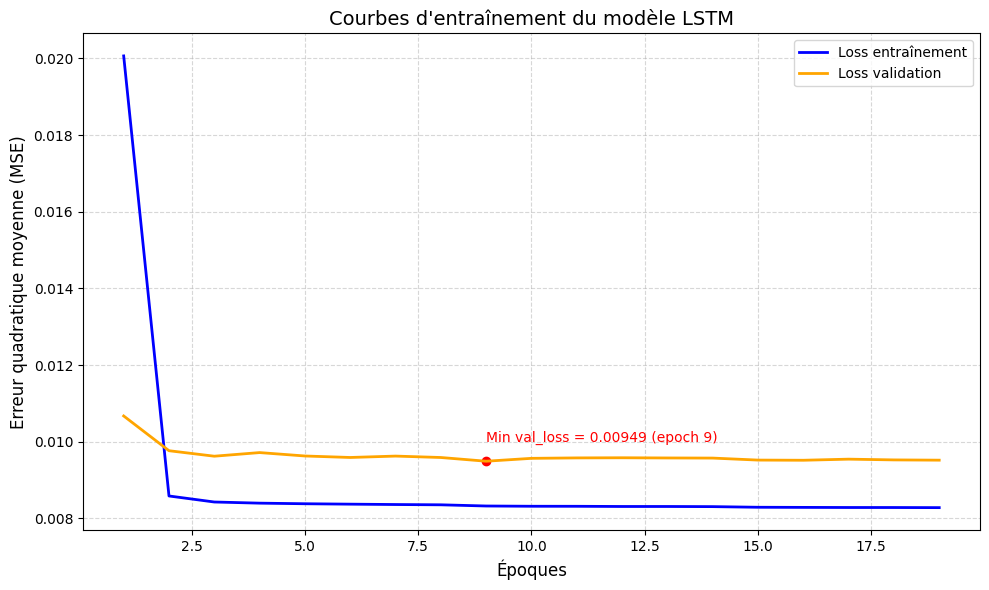

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Récupération des données
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Loss entraînement', color='blue', linewidth=2)
plt.plot(epochs, val_loss, label='Loss validation', color='orange', linewidth=2)

# Annotation du meilleur val_loss
min_val_epoch = np.argmin(val_loss) + 1
min_val = np.min(val_loss)
plt.scatter(min_val_epoch, min_val, color='red')
plt.text(min_val_epoch, min_val + 0.0005, f"Min val_loss = {min_val:.5f} (epoch {min_val_epoch})", color='red')

# Mise en forme
plt.title("Courbes d'entraînement du modèle LSTM", fontsize=14)
plt.xlabel("Époques", fontsize=12)
plt.ylabel("Erreur quadratique moyenne (MSE)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# 10) Évaluation & reconstruction multi‑step
# =====================================================
best = keras.models.load_model(BEST_MODEL_PATH)
Y_test_pred_flat = best.predict(X_test, batch_size=BATCH_SIZE, verbose=0)

# Remettre en [M, horizon, 4]
Y_test_pred = Y_test_pred_flat.reshape((-1, FORECAST_HORIZON, 4))
Y_test_true = Y_test.reshape((-1, FORECAST_HORIZON, 4))

# Inverse scaling par pas (applique scaler_y sur l'axe features)
Y_pred_inv = scaler_y.inverse_transform(Y_test_pred.reshape(-1, 4)).reshape(-1, FORECAST_HORIZON, 4)
Y_true_inv = scaler_y.inverse_transform(Y_test_true.reshape(-1, 4)).reshape(-1, FORECAST_HORIZON, 4)

print("Shapes inv:", Y_true_inv.shape, Y_pred_inv.shape)

# Métriques agrégées (MAE / RMSE) sur tout l'horizon et variables
mae = np.mean(np.abs(Y_true_inv - Y_pred_inv))
rmse = np.sqrt(np.mean((Y_true_inv - Y_pred_inv)**2))
print({"MAE": float(mae), "RMSE": float(rmse)})


Shapes inv: (81031, 6, 4) (81031, 6, 4)
{'MAE': 2.7828412633075095, 'RMSE': 5.3785797188078055}


81031 est le nombre de séquences (nombre de prédictions que vous avez faites).

6 est l'horizon de prévision (6 heures à l'avance).

4 est le nombre de variables que vous prédisez (temp, humidity, co, lpg).

In [28]:
mae_par_variable = np.mean(np.abs(Y_true_inv - Y_pred_inv), axis=(0, 1))


# Affiche les résultats pour chaque variable
print(f"MAE Température : {mae_par_variable[0]:.2f} °C")
print(f"MAE Humidité : {mae_par_variable[1]:.2f} %")
print(f"MAE CO : {mae_par_variable[2]:.4f}")
print(f"MAE LPG : {mae_par_variable[3]:.4f}")

MAE Température : 2.38 °C
MAE Humidité : 8.75 %
MAE CO : 0.0010
MAE LPG : 0.0011


Comparaison MAE/RMSE par variable et par horizon

In [29]:
errors = Y_true_inv - Y_pred_inv
abs_errors = np.abs(errors)        # pour MAE
sq_errors = errors ** 2            # pour RMSE

# Moyenne par variable et par horizon
mae_per_var_horizon = np.mean(abs_errors, axis=0)  # (horizon, 4)
rmse_per_var_horizon = np.sqrt(np.mean(sq_errors, axis=0))  # (horizon, 4)

# DataFrame lisible
horizons = np.arange(1, mae_per_var_horizon.shape[0] + 1)
df_metrics = pd.DataFrame()

for v, name in enumerate(["Température (°C)", "Humidité (%)", "CO", "LPG"]):
    for h in horizons:
        df_metrics = pd.concat([df_metrics, pd.DataFrame({
            "Variable": [name],
            "Horizon": [h],
            "MAE": [mae_per_var_horizon[h-1, v]],
            "RMSE": [rmse_per_var_horizon[h-1, v]]
        })], ignore_index=True)

# Aperçu
print(df_metrics.head(12))


            Variable  Horizon       MAE       RMSE
0   Température (°C)        1  2.240618   2.948474
1   Température (°C)        2  2.365890   3.168107
2   Température (°C)        3  2.404473   3.227757
3   Température (°C)        4  2.402138   3.281663
4   Température (°C)        5  2.420155   3.273143
5   Température (°C)        6  2.421962   3.290317
6       Humidité (%)        1  7.002590   8.708866
7       Humidité (%)        2  8.838425  10.366676
8       Humidité (%)        3  9.048410  10.503017
9       Humidité (%)        4  9.119111  10.605483
10      Humidité (%)        5  9.316428  10.625721
11      Humidité (%)        6  9.195339  10.669263


Visualisation MAE et RMSE par horizon

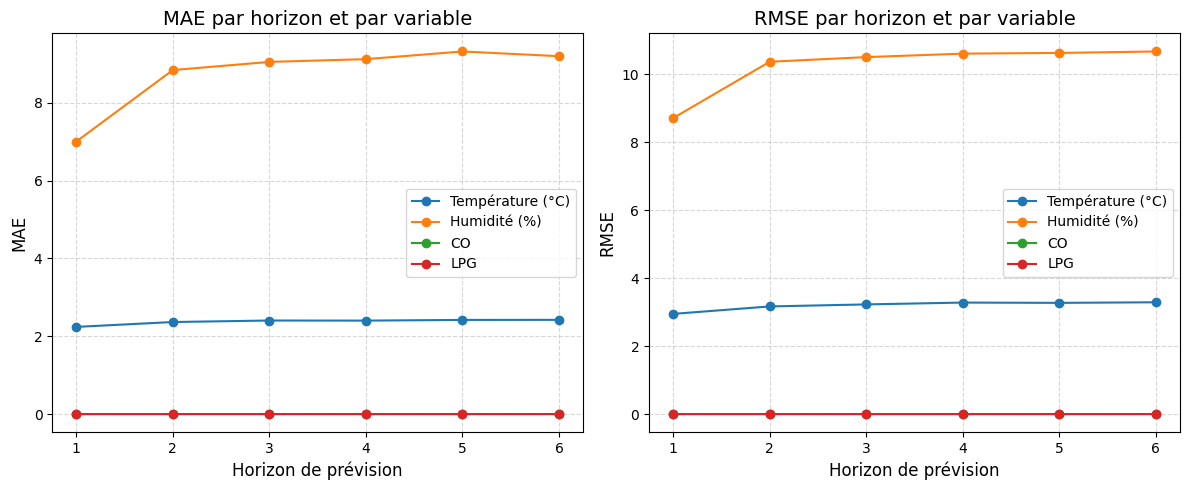

In [30]:
variables = ["Température (°C)", "Humidité (%)", "CO", "LPG"]
horizons = np.arange(1, mae_per_var_horizon.shape[0] + 1)

plt.figure(figsize=(12, 5))

# ---- Graphique MAE ----
plt.subplot(1, 2, 1)
for v, name in enumerate(variables):
    plt.plot(horizons, mae_per_var_horizon[:, v], marker='o', label=name)
plt.title("MAE par horizon et par variable", fontsize=14)
plt.xlabel("Horizon de prévision", fontsize=12)
plt.ylabel("MAE", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

# ---- Graphique RMSE ----
plt.subplot(1, 2, 2)
for v, name in enumerate(variables):
    plt.plot(horizons, rmse_per_var_horizon[:, v], marker='o', label=name)
plt.title("RMSE par horizon et par variable", fontsize=14)
plt.xlabel("Horizon de prévision", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Visualisations Réel vs Prédit

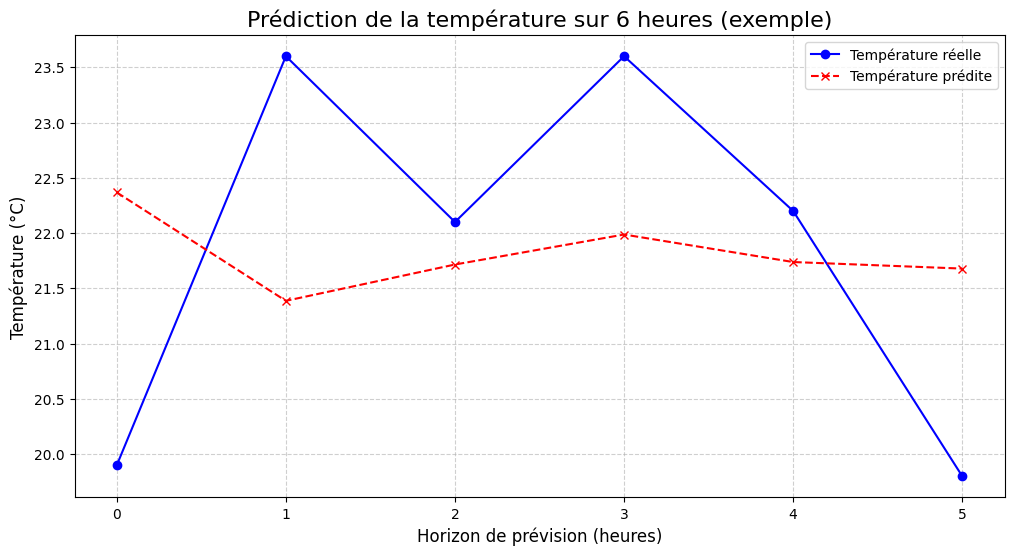

In [31]:
# Choix d'une séquence à visualiser (la première, par exemple)
sequence_index = 0

# Les indices des colonnes de votre variable (température est la première)
temp_index = 0

# Tracer le graphique
plt.figure(figsize=(12, 6))
plt.plot(Y_true_inv[sequence_index, :, temp_index], label='Température réelle', color='blue', marker='o')
plt.plot(Y_pred_inv[sequence_index, :, temp_index], label='Température prédite', color='red', linestyle='--', marker='x')

# Mise en forme du graphique
plt.title("Prédiction de la température sur 6 heures (exemple)", fontsize=16)
plt.xlabel("Horizon de prévision (heures)", fontsize=12)
plt.ylabel("Température (°C)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [32]:
# 11) Détection d'anomalies (μ + 3σ)
# =======================================
# Baseline sur train
Y_train_pred_flat = best.predict(X_train2, batch_size=BATCH_SIZE, verbose=0)
Y_train_pred = Y_train_pred_flat.reshape(-1, FORECAST_HORIZON, 4)
Y_train_true = Y_train2.reshape(-1, FORECAST_HORIZON, 4)

Y_train_pred_inv = scaler_y.inverse_transform(Y_train_pred.reshape(-1,4)).reshape(-1, FORECAST_HORIZON, 4)
Y_train_true_inv = scaler_y.inverse_transform(Y_train_true.reshape(-1,4)).reshape(-1, FORECAST_HORIZON, 4)

# Erreur RMSE par (échantillon, step)
err_train = np.sqrt(np.mean((Y_train_true_inv - Y_train_pred_inv)**2, axis=2))  # shape [M_train, horizon]
mu, sigma = float(err_train.mean()), float(err_train.std())
threshold = mu + 3.0 * sigma
print(f"Seuil anomalies = {threshold:.4f} (mu={mu:.4f}, sigma={sigma:.4f})")

# Test errors & flags
err_test = np.sqrt(np.mean((Y_true_inv - Y_pred_inv)**2, axis=2))  # [M_test, horizon]
flags_test = (err_test > threshold).astype(int)

# Construire un DataFrame long (timestamp, step, error, is_anomaly)
rows = []
for i in range(len(T_test)):
    for h in range(FORECAST_HORIZON):
        rows.append({
            'timestamp': pd.to_datetime(T_test[i, h]),
            'step': h+1,
            'error_rmse': float(err_test[i, h]),
            'is_anomaly': int(flags_test[i, h])
        })

df_anoms = pd.DataFrame(rows).sort_values(['timestamp','step']).reset_index(drop=True)
print("Aperçu anomalies:")
print(df_anoms.head())


Seuil anomalies = 12.0297 (mu=4.8740, sigma=2.3852)
Aperçu anomalies:
                      timestamp  step  error_rmse  is_anomaly
0 2020-07-18 09:41:19.348628759     1    5.711132           0
1 2020-07-18 09:41:19.958857775     1    1.731687           0
2 2020-07-18 09:41:19.958857775     2    1.214442           0
3 2020-07-18 09:41:22.471203566     1    1.201889           0
4 2020-07-18 09:41:22.471203566     2    4.507245           0


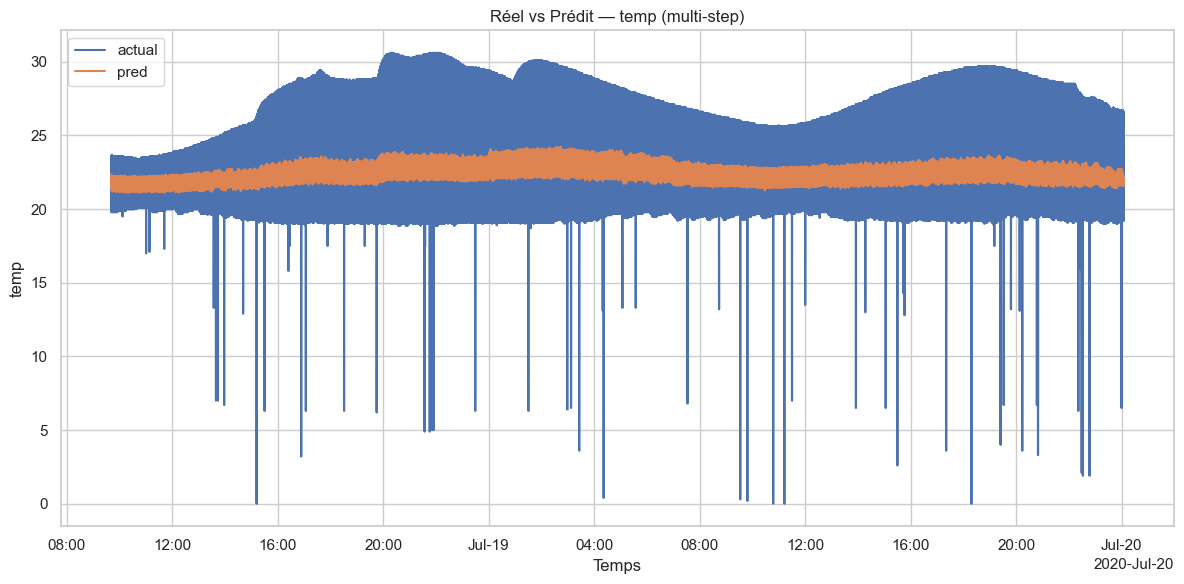

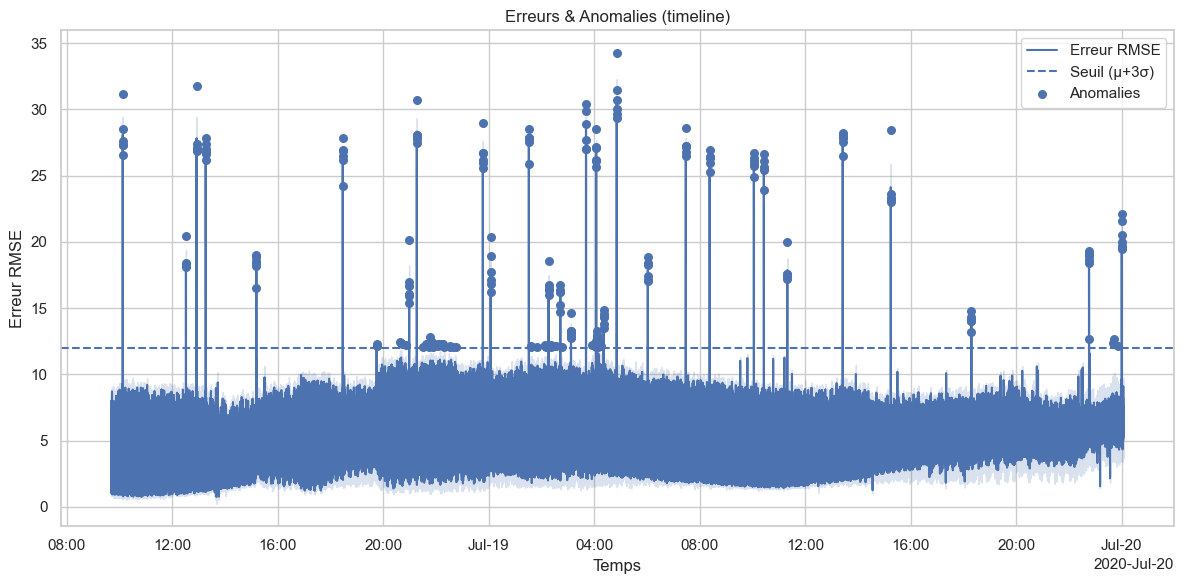

In [33]:

sns.set_theme(context="notebook", style="whitegrid")

# 12.0 — Préparation des données (identique à ton code)
var_idx = 0  # 0=temp, 1=humidity, 2=co, 3=lpg
var_name = TARGET_COLS[var_idx]

rows_series = []
for i in range(len(T_test)):
    for h in range(FORECAST_HORIZON):
        ts = pd.to_datetime(T_test[i, h])
        rows_series.append({
            'timestamp': ts,
            'horizon_step': h+1,
            'actual': float(Y_true_inv[i, h, var_idx]),
            'pred': float(Y_pred_inv[i, h, var_idx])
        })

df_series = pd.DataFrame(rows_series).sort_values(['timestamp','horizon_step'])

# 12.1 — Réel vs Prédit
plot_df = df_series[['timestamp', 'actual', 'pred']].melt(
    id_vars='timestamp', var_name='type', value_name='value'
)

plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=plot_df, x='timestamp', y='value', hue='type')
ax.set_title(f"Réel vs Prédit — {var_name} (multi-step)")
ax.set_xlabel("Temps")
ax.set_ylabel(var_name)

# Joli format de dates sur l'axe X
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend(title="")
plt.tight_layout()
plt.show()

# 12.2 — Erreurs & Anomalies (timeline)
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=df_anoms, x='timestamp', y='error_rmse', label='Erreur RMSE')
ax.axhline(threshold, linestyle='--', label='Seuil (μ+3σ)')

# Marqueurs anomalies
anom_pts = df_anoms[df_anoms['is_anomaly'] == 1]
plt.scatter(anom_pts['timestamp'], anom_pts['error_rmse'], s=30, label='Anomalies')

ax.set_title('Erreurs & Anomalies (timeline)')
ax.set_xlabel('Temps')
ax.set_ylabel('Erreur RMSE')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend()
plt.tight_layout()
plt.show()

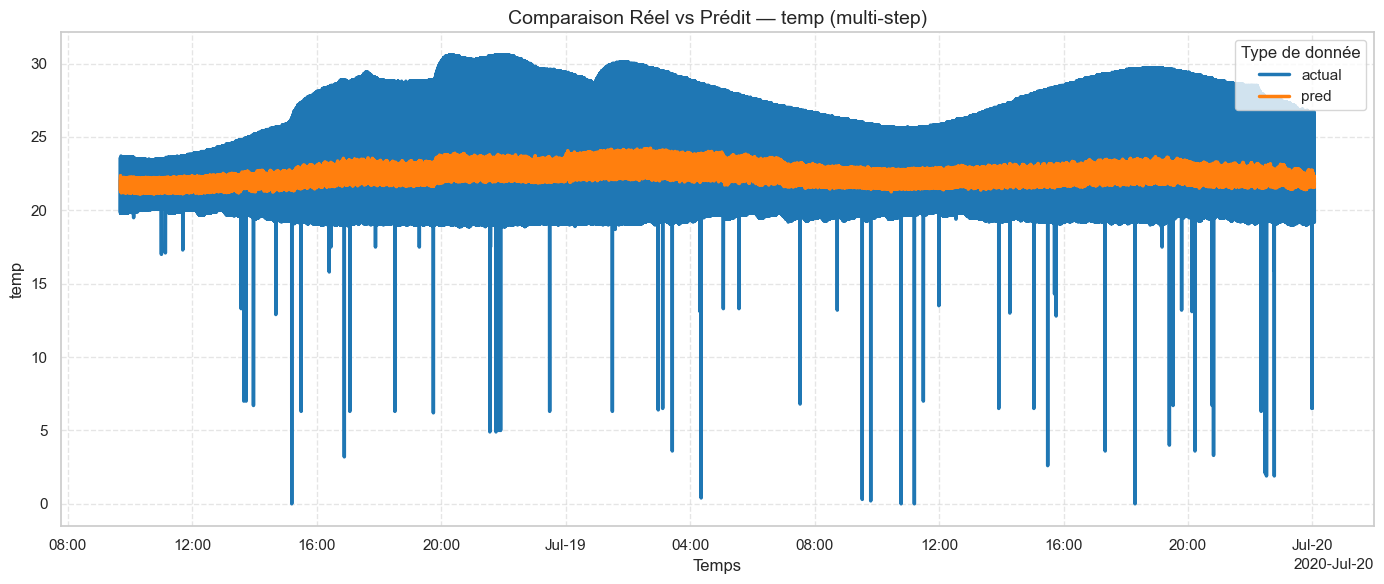

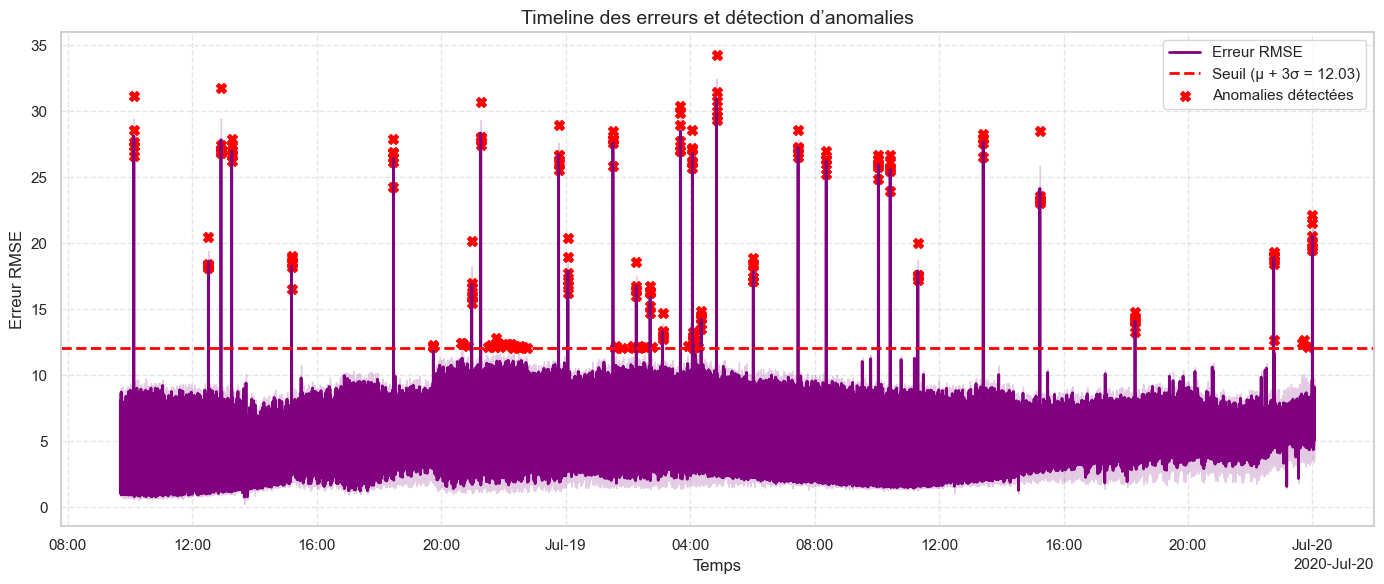

In [34]:
sns.set_theme(context="notebook", style="whitegrid")

# 12.0 — Préparation des données pour la variable choisie
var_idx = 0  # 0=temp, 1=humidity, 2=co, 3=lpg
var_name = TARGET_COLS[var_idx]

rows_series = []
for i in range(len(T_test)):
    for h in range(FORECAST_HORIZON):
        ts = pd.to_datetime(T_test[i, h])
        rows_series.append({
            'timestamp': ts,
            'horizon_step': h + 1,
            'actual': float(Y_true_inv[i, h, var_idx]),
            'pred': float(Y_pred_inv[i, h, var_idx])
        })

df_series = pd.DataFrame(rows_series).sort_values(['timestamp', 'horizon_step'])

# 12.1 — Réel vs Prédit (multi-step)
plot_df = df_series[['timestamp', 'actual', 'pred']].melt(
    id_vars='timestamp', var_name='type', value_name='value'
)

plt.figure(figsize=(14, 6))
palette = {'actual': '#1f77b4', 'pred': '#ff7f0e'}  # Bleu pour réel, orange pour prédit
ax = sns.lineplot(data=plot_df, x='timestamp', y='value', hue='type', palette=palette, linewidth=2.5)

ax.set_title(f"Comparaison Réel vs Prédit — {var_name} (multi-step)", fontsize=14)
ax.set_xlabel("Temps", fontsize=12)
ax.set_ylabel(var_name, fontsize=12)

# Format de date lisible
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend(title="Type de donnée", loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 12.2 — Erreurs & Anomalies (timeline)
plt.figure(figsize=(14, 6))
ax = sns.lineplot(data=df_anoms, x='timestamp', y='error_rmse', label='Erreur RMSE', color='purple', linewidth=2)

# Ligne de seuil
ax.axhline(threshold, linestyle='--', color='red', label=f'Seuil (μ + 3σ = {threshold:.2f})', linewidth=2)

# Marqueurs anomalies
anom_pts = df_anoms[df_anoms['is_anomaly'] == 1]
plt.scatter(anom_pts['timestamp'], anom_pts['error_rmse'], s=50, color='red', label='Anomalies détectées', marker='X')

ax.set_title('Timeline des erreurs et détection d’anomalies', fontsize=14)
ax.set_xlabel('Temps', fontsize=12)
ax.set_ylabel('Erreur RMSE', fontsize=12)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [35]:
# 13) Conversion TensorFlow Lite & inférence
# =============================================
# Sauvegarde et conversion
model_best = keras.models.load_model(BEST_MODEL_PATH)
converter = tf.lite.TFLiteConverter.from_keras_model(model_best)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # optimisation dynamique

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# ⚠️ Sortie plate (horizon*4) => pratique pour TFLite

tflite_model = converter.convert()
with open(TFLITE_PATH, 'wb') as f:
    f.write(tflite_model)
print("TFLite écrit:", TFLITE_PATH, "taille:", os.path.getsize(TFLITE_PATH))

# Exemple d'inférence TFLite sur un batch test
sample = X_test[:1].astype(np.float32)  # (1, LOOK_BACK, n_features)
interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)

interpreter.set_tensor(input_details[0]['index'], sample)
interpreter.invoke()
output_flat = interpreter.get_tensor(output_details[0]['index'])  # (1, horizon*4)

# Post‑traitement: reshape + inverse scaling
output_seq = output_flat.reshape(-1, FORECAST_HORIZON, 4)
output_inv = scaler_y.inverse_transform(output_seq.reshape(-1,4)).reshape(-1, FORECAST_HORIZON, 4)
print("Prédiction TFLite (1er batch) shape:", output_inv.shape)
print("Step1 (dé‑normalisé):", output_inv[0,0])


INFO:tensorflow:Assets written to: C:\Users\Macky\AppData\Local\Temp\tmpkctvyp9j\assets


INFO:tensorflow:Assets written to: C:\Users\Macky\AppData\Local\Temp\tmpkctvyp9j\assets


Saved artifact at 'C:\Users\Macky\AppData\Local\Temp\tmpkctvyp9j'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 8), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  2289339972304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257247952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257246800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257247376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257239504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257239120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257237392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257234704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289257239312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2289259816592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  228925981

c:\Users\Macky\Documents\Projet_St\Classification_d'images\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


RuntimeError: Select TensorFlow op(s), included in the given model, is(are) not supported by this interpreter. Make sure you apply/link the Flex delegate before inference. For the Android, it can be resolved by adding "org.tensorflow:tensorflow-lite-select-tf-ops" dependency. See instructions: https://www.tensorflow.org/lite/guide/ops_selectNode number 1 (FlexTensorListReserve) failed to prepare.

In [36]:
# 14) Utilitaires: export des scalers
# =============================================

def export_minmax_to_json(scaler: MinMaxScaler, feature_names, path):
    data = {
        "feature_names": list(feature_names),
        "min_": scaler.data_min_.tolist(),
        "max_": scaler.data_max_.tolist(),
        "scale_": scaler.scale_.tolist(),
        "min_offset_": scaler.min_.tolist(),
        "data_range_": scaler.data_range_.tolist()
    }
    with open(path, 'w') as f:
        json.dump(data, f, indent=2)

export_minmax_to_json(scaler_all, feature_cols, str(SCALERS_DIR / 'scaler_all.json'))
export_minmax_to_json(scaler_y, TARGET_COLS, str(SCALERS_DIR / 'scaler_y.json'))
print("Scalers exportés dans:", SCALERS_DIR)


Scalers exportés dans: Version_3_artifacts\Version_3s_scalers
